In [1]:
import numpy as np
import pandas as pd
import pickle
import logging
from typing import Tuple
import sys
sys.path.append(r'E:\photoelectric_sorting\codes\project_x_ray_images_stack')
from tools.analyzer_two_thresh import BaselineOreGrading

import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
# 定义 load_data 函数
def load_data(
        pixel_file: str,
        date: str,
        annotation_file: str
) -> Tuple[pd.DataFrame, pd.Series]:
    """
    加载并预处理像素数据和注释数据。

    参数:
    - pixel_file (str): 包含像素数据的 pickle 文件路径。
    - annotation_file (str): 包含注释数据的 Excel 文件路径。

    返回:
    - Tuple 包含:
        - ann (pd.DataFrame): 预处理后的注释 DataFrame。
        - pixels (pd.Series): 预处理后的像素 Series。
    """
    try:
        # 加载注释数据
        ann = pd.read_excel(annotation_file)
        ann = ann.loc[:, ~ann.columns.str.contains('^Unnamed')]
        ann.rename(columns={
            'Fe': "Fe_grade",
            'Zn': "Zn_grade",
            'Pb': "Pb_grade",
            'S': "S_grade",
            'Weight(g)': "weight"
        }, inplace=True)
        
        # 加载像素数据
        with open(pixel_file, 'rb') as f:
            pixels_data = pickle.load(f)
        pixels = pd.Series(pixels_data[date]['low'][:len(ann.iloc[:,0])])

        # 处理缺失数据
        none_indexes = pixels[pixels.isnull()].index.tolist()
        missing_indexes = ann[ann.isnull().any(axis=1)].index.tolist()
        indexes_to_remove = set(none_indexes).union(missing_indexes)
        pixels = pixels.drop(indexes_to_remove)
        ann = ann.drop(indexes_to_remove)

        logging.info(f"加载数据完成。清洗后的样本数量: {len(ann)}")
        return ann, pixels
    except Exception as e:
        logging.error(f"加载数据时出错: {e}")
        raise

In [57]:
# path = "E:/photoelectric_sorting/240822_190铅锌矿_单矿石XRT图片/"
# pixel_file = path + "240822_190rock_pixel_values.pkl"
# annotation_file = path + "20240822铅锌190块.xlsx"

pixel_file = "E:/photoelectric_sorting/codes/jt_ore_sorting/2025rock_pixel_values.pkl"
annotation_file = "E:/photoelectric_sorting/data/化验结果/20250219化验结果.xlsx"
ann, pixels = load_data(pixel_file, '0219', annotation_file)

2025-03-14 11:25:08,790 - INFO - 加载数据完成。清洗后的样本数量: 98


In [50]:
len(ann)

98

In [55]:
pixel_file = "E:/photoelectric_sorting/codes/jt_ore_sorting/2025rock_pixel_values.pkl"
annotation_file_xu = "E:/photoelectric_sorting/data/化验结果/20250219化验结果_许杰.xlsx"
ann_xu, pixels_xu = load_data(pixel_file, '0219', annotation_file_xu)

2025-03-14 11:20:21,502 - INFO - 加载数据完成。清洗后的样本数量: 98


In [56]:
comparison = ann.iloc[:, 0:4].compare(ann_xu.iloc[:, 0:4])
pd.set_option('display.max_rows', None) 
print(comparison)

Empty DataFrame
Columns: []
Index: []


2025-03-14 11:25:12,468 - INFO - 开始进行超参数调优...



=== 最佳超参数 ===
灰度阈值: 15
比例阈值: 0.00%

=== 调优指标 ===
抛废率: 26.93%
回收率: 96.44%
铅富集比: 147.48%
锌富集比: 144.10%
铅平均品位（保留）: 3.47%
锌平均品位（保留）: 4.90%
铅平均品位（抛废）: 0.25%
锌平均品位（抛废）: 0.58%
铅平均品位: 2.35%
锌平均品位: 3.40%

=== 基于品位阈值2.50%的二分类指标 ===
准确率: 66.33%
精确率: 53.12%
召回率: 91.89%
F1 分数: 67.33%

=== AUC 结果 ===
AUC_基于化验品位: 0.8670
AUC_双阈值算法: 0.7984
AUC_平均值算法: 0.7800

=== 95%回收率指标 ===
当回收率约为 95.18% 时，抛废率为 27.25%。此时的灰度阈值为25.0，比例阈值为5.00%。


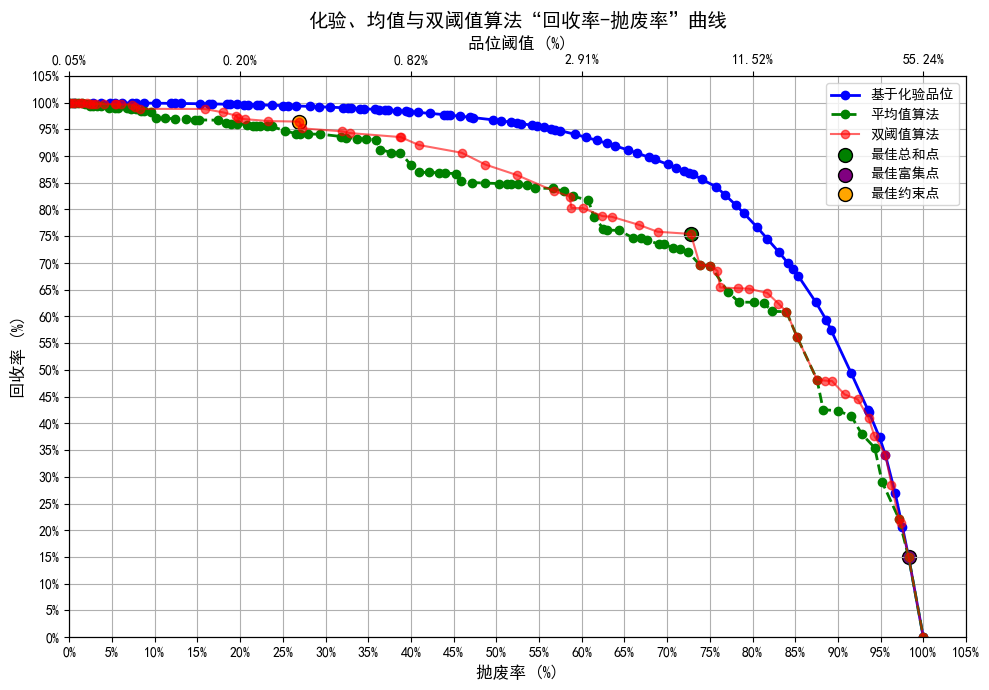

In [58]:
"""
主函数，用于执行超参数调优、计算指标并绘制曲线。
"""
# 配置日志以显示 INFO 级别的消息
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')    

# 初始化 BaselineOreGrading 模型
baseline_model = BaselineOreGrading(ann=ann, pixels=pixels)

# 执行超参数调优
best_params, best_tuning_metrics = baseline_model.hyperparameter_tuning(
    min_recovery_rate=0.95,
    min_scrap_rate=0.2,
    step_A=5,
    step_B=0.05
)

if best_params:
    best_threshold_A, best_threshold_B = best_params
    print("\n=== 最佳超参数 ===")
    print(f"灰度阈值: {best_threshold_A}")
    print(f"比例阈值: {best_threshold_B * 100:.2f}%")

    # 使用最佳超参数进行矿石分类
    predictions = baseline_model.classify_ores(best_threshold_A, best_threshold_B)

    grade_threshold = 0.025
    # 使用最佳超参数计算基于品位的指标
    grade_based_metrics = baseline_model.calculate_grade_based_metrics(
        predictions=predictions,
        grade_threshold=grade_threshold
    )

    print("\n=== 调优指标 ===")
    for metric, value in best_tuning_metrics.items():
        print(f"{metric}: {value:.2%}")

    print(f"\n=== 基于品位阈值{grade_threshold*100:.2f}%的二分类指标 ===")
    for metric, value in grade_based_metrics.items():
        print(f"{metric}: {value:.2%}")
else:
    print("未找到符合指定约束条件的合适参数。")

# 计算曲线数据
try:
    scrap_rates_ideal, recovery_rates_ideal, grade_thresholds_ideal = baseline_model.compute_ideal_curve()
    scrap_rates_baseline, recovery_rates_baseline, grade_thresholds_baseline = baseline_model.compute_baseline_curve()
    pareto_front = baseline_model.pareto_front
except Exception as e:
    logging.error(f"计算曲线时出错: {e}")

# 计算 AUC 结果
auc_results = baseline_model.compute_auc(scrap_rates_ideal, recovery_rates_ideal)

# 显示 AUC 结果
print("\n=== AUC 结果 ===")
for key, value in auc_results.items():
    if not np.isnan(value):
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: 未计算")

# 识别最佳点
best_sum_point = None
best_enrichment_point = None
best_constraint_point = None

if not pareto_front.empty:
    # 1. 最佳总和点（最大抛废率 + 回收率）
    pareto_front['score_sum'] = pareto_front['抛废率'] + pareto_front['回收率']
    best_sum_point = pareto_front.loc[pareto_front['score_sum'].idxmax()]

    # 2. 最佳富集点（最大铅和锌富集比之和）
    pareto_front['enrichment_sum'] = pareto_front['铅富集比'] + pareto_front['锌富集比']
    best_enrichment_point = pareto_front.loc[pareto_front['enrichment_sum'].idxmax()]

    # 3. 最佳约束点（如果存在）
    if baseline_model.best_under_constraints:
        best_constraint_point = pd.Series({
            'threshold_A': baseline_model.best_under_constraints[0],
            'threshold_B': baseline_model.best_under_constraints[1],
            '抛废率': baseline_model.best_under_constraints[2]['抛废率'],
            '回收率': baseline_model.best_under_constraints[2]['回收率'],
            '铅富集比': baseline_model.best_under_constraints[2]['铅富集比'],
            '锌富集比': baseline_model.best_under_constraints[2]['锌富集比'],
            '品位阈值': (baseline_model.best_under_constraints[2]['抛废率'] +
                            baseline_model.best_under_constraints[2]['回收率']) / 2
        })
else:
    logging.warning("没有可用的 Pareto 前沿来识别最佳点。")

# 找到最接近目标回收率的点
target_recovery = 0.95
closest_point = baseline_model.find_closest_point(target_recovery)

# 获取 closest_point 对应的 灰度阈值 和 比例阈值
if closest_point:
    print(f"\n=== 95%回收率指标 ===")
    scrap, recovery = closest_point
    matching_rows = pareto_front[
        (pareto_front['抛废率'] == scrap) & (pareto_front['回收率'] == recovery)
    ]
    if not matching_rows.empty:
        closest_threshold_A = matching_rows.iloc[0]['threshold_A']
        closest_threshold_B = matching_rows.iloc[0]['threshold_B']
        print(f"当回收率约为 {recovery * 100:.2f}% 时，抛废率为 {scrap * 100:.2f}%。此时的灰度阈值为{closest_threshold_A}，比例阈值为{closest_threshold_B * 100:.2f}%。")
    else:
        print(f"当回收率约为 {recovery * 100:.2f}% 时，抛废率为 {scrap * 100:.2f}%。阈值信息不可用。")
else:
    print("未找到符合条件的抛废率和回收率。")

# 绘制曲线
baseline_model.plot_curves(
    scrap_rates_ideal=scrap_rates_ideal,
    recovery_rates_ideal=recovery_rates_ideal,
    grade_thresholds_ideal=grade_thresholds_ideal,
    scrap_rates_baseline=scrap_rates_baseline,
    recovery_rates_baseline=recovery_rates_baseline,
    pareto_front=pareto_front,
    best_sum_point=best_sum_point,
    best_enrichment_point=best_enrichment_point,
    best_constraint_point=best_constraint_point)

In [62]:
pareto_sorted = baseline_model.pareto_front.sort_values('抛废率')
results_dual_thresh = np.array((pareto_sorted['抛废率'], pareto_sorted['回收率']))
np.save('results_dual_thresh.npy', results_dual_thresh)